In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import utils.metrics as utils_metrics

In [3]:
import hashlib

In [4]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [57]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [8]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [9]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [10]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [11]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [ ]:
aggregate_rover_with_clf_

In [94]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              0,
                                              cluster_refernces, 
                                              print_)

In [95]:
import matplotlib.pyplot as plt

In [96]:
import pickle

In [97]:
with open('../notebooks/pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [98]:
import seaborn as sns
sns.set(style="whitegrid")

In [201]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
#             scores = sorted([(value, score) for value, score in item1], key=lambda x: x[1])
#             score = scores[-1][1]
            tokens = [value for value, score_ in item1 if value != ""]
            if score < treshhold:
                tokens = []
                prev_question = False
                for value, score_ in item1:
                    if score_ > threshold_by_word and value != "" and value != "?":
                        tokens.append(value)
                        prev_question = False
                    elif not prev_question and value != "":
                        tokens.append("?")
                        changed_signs_in_aggregated += 1
                        prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    # print("Number of changed \'?\': {}".format(changed_signs_in_aggregated))
    return results

In [202]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6846747656650313)],
 2: [('', 0.8797422806822525)],
 3: [('', 0.935914017338639)],
 4: [('', 0.9476157703498646)],
 5: [('', 0.9642552025849801)],
 6: [('', 0.9860052903329602)],
 7: [('', 0.9829542698996759)],
 8: [('', 0.9819593114274828)],
 9: [('', 0.9882454214427111)],
 10: [('', 0.9902087289873817)]}

In [203]:
res_with_words = aggregate_rover_with_clf_by_word(valid_rows, 
                                 {},
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 None, 
                                 threshold_by_word=0.8210526315789474,
                                 treshhold=0.948,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

In [204]:
pd.DataFrame(list(res_with_words.values())).sample(20)

,text,confidence,cost
10,порно,0.953656,5
2072,? закончите ну пожалуйста покажи сколько стоят...,0.937737,7
852,хорошо алиса у тебя есть попа,0.968527,4
1520,None,0.911829,7
1869,None,0.875271,7
1226,выглядите,0.979341,3
3052,,0.971795,3
847,нет ты не то показала,0.988961,3
598,,0.963742,3
795,,0.961267,4


In [177]:
conf_0 = 0
for key, value in res_with_words.items():
    if value.confidence == 0:
        conf_0 += 1
conf_0 / len(res_with_words)

0.0

In [178]:
from functools import partial

In [179]:
from collections import defaultdict

In [180]:
threshhold = 0.948
evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_, 
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


(0.8560986032503954, 0.06822048315753658, 4.0014343086632245)

In [181]:
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [233]:
scores_clf_score_by_word_q_mean_v3 = defaultdict(list)

for threshhold in [0.945, 0.946, 0.947, 0.948, 0.949, 0.950, 0.951, 0.952, 0.953, 0.954, 0.955, 0.956]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.85, 1, 31):
        if threshhold == 1 and th_by_word == 1:
            continue
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))
        if metrics[0] < baseline_loaded_new_metrics[1]:
            break
        if metrics[0] >= baseline_loaded_new_metrics[1] and metrics[1] < baseline_loaded_new_metrics[2]:
            scores_clf_score_by_word_q_mean_v3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v3[threshhold] = np.array(scores_clf_score_by_word_q_mean_v3[threshhold])


0.945
0.85
Recall: 89.0513%
WER: 7.9650%
Mean overlap: 3.948
0.855
Recall: 88.9832%
WER: 7.9075%
Mean overlap: 3.948
0.86
Recall: 88.9603%
WER: 7.8746%
Mean overlap: 3.948
0.865
Recall: 88.9360%
WER: 7.8356%
Mean overlap: 3.948
0.87
Recall: 88.9079%
WER: 7.7731%
Mean overlap: 3.948
0.875
Recall: 88.8645%
WER: 7.7581%
Mean overlap: 3.948
0.88
Recall: 88.8255%
WER: 7.7521%
Mean overlap: 3.948
0.885
Recall: 88.7832%
WER: 7.7062%
Mean overlap: 3.948
0.89
Recall: 88.7330%
WER: 7.6905%
Mean overlap: 3.948
0.895
Recall: 88.6757%
WER: 7.6499%
Mean overlap: 3.948
0.9
Recall: 88.5589%
WER: 7.5964%
Mean overlap: 3.948
0.905
Recall: 88.5070%
WER: 7.5344%
Mean overlap: 3.948
0.91
Recall: 88.4156%
WER: 7.5111%
Mean overlap: 3.948
0.915
Recall: 88.3318%
WER: 7.4717%
Mean overlap: 3.948
0.9199999999999999
Recall: 88.3023%
WER: 7.4714%
Mean overlap: 3.948
0.925
Recall: 88.2613%
WER: 7.4321%
Mean overlap: 3.948
0.9299999999999999
Recall: 88.2105%
WER: 7.3968%
Mean overlap: 3.948
0.935
Recall: 88.1627%


Recall: 86.9805%
WER: 6.8503%
Mean overlap: 4.017
0.96
Recall: 86.8479%
WER: 6.7950%
Mean overlap: 4.017
0.965
Recall: 86.6783%
WER: 6.7316%
Mean overlap: 4.017
0.97
Recall: 86.5508%
WER: 6.7111%
Mean overlap: 4.017
0.975
Recall: 86.3709%
WER: 6.6915%
Mean overlap: 4.017
0.98
Recall: 86.2035%
WER: 6.6955%
Mean overlap: 4.017
0.985
Recall: 85.9053%
WER: 6.7170%
Mean overlap: 4.017
0.99
Recall: 85.5579%
WER: 6.7170%
Mean overlap: 4.017

0.95
0.85
Recall: 88.2430%
WER: 7.5605%
Mean overlap: 4.049
0.855
Recall: 88.1736%
WER: 7.5029%
Mean overlap: 4.049
0.86
Recall: 88.1364%
WER: 7.4549%
Mean overlap: 4.049
0.865
Recall: 88.1096%
WER: 7.4165%
Mean overlap: 4.049
0.87
Recall: 88.0651%
WER: 7.3542%
Mean overlap: 4.049
0.875
Recall: 88.0200%
WER: 7.3392%
Mean overlap: 4.049
0.88
Recall: 87.9765%
WER: 7.3339%
Mean overlap: 4.049
0.885
Recall: 87.9124%
WER: 7.2883%
Mean overlap: 4.049
0.89
Recall: 87.8544%
WER: 7.2681%
Mean overlap: 4.049
0.895
Recall: 87.7828%
WER: 7.2274%
Mean overlap: 4.049
0

Recall: 85.6781%
WER: 6.5209%
Mean overlap: 4.178
0.925
Recall: 85.6139%
WER: 6.4859%
Mean overlap: 4.178
0.9299999999999999
Recall: 85.5362%
WER: 6.4458%
Mean overlap: 4.178

0.956
0.85
Recall: 86.7047%
WER: 7.1197%
Mean overlap: 4.216
0.855
Recall: 86.6185%
WER: 7.0625%
Mean overlap: 4.216
0.86
Recall: 86.5527%
WER: 7.0000%
Mean overlap: 4.216
0.865
Recall: 86.5061%
WER: 6.9470%
Mean overlap: 4.216
0.87
Recall: 86.4473%
WER: 6.8842%
Mean overlap: 4.216
0.875
Recall: 86.3769%
WER: 6.8622%
Mean overlap: 4.216
0.88
Recall: 86.2816%
WER: 6.8583%
Mean overlap: 4.216
0.885
Recall: 86.1934%
WER: 6.7845%
Mean overlap: 4.216
0.89
Recall: 86.0822%
WER: 6.7426%
Mean overlap: 4.216
0.895
Recall: 85.9948%
WER: 6.7031%
Mean overlap: 4.216
0.9
Recall: 85.8096%
WER: 6.6130%
Mean overlap: 4.216
0.905
Recall: 85.7482%
WER: 6.5506%
Mean overlap: 4.216
0.91
Recall: 85.6110%
WER: 6.5300%
Mean overlap: 4.216
0.915
Recall: 85.5117%
WER: 6.4843%
Mean overlap: 4.216


In [217]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

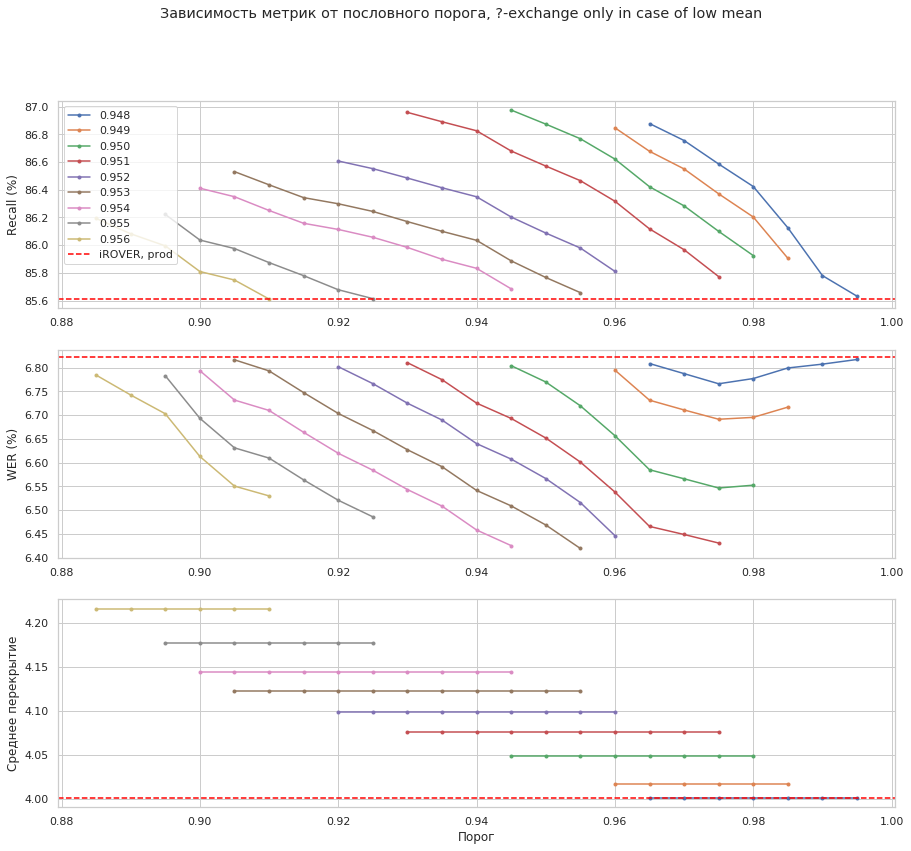

In [237]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label='{:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [238]:
scores_clf_score_by_word_q_mean_v3[0.950][0]

array([0.945     , 0.86975996, 0.06804374, 4.04905336])

In [215]:
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [226]:
needed_points = []
default = (None, 0, 1, 10)
for threshold, metrics in scores_clf_score_by_word_q_mean_v3.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points.append(prev)   
needed_points.append(['baseline'] + list(baseline_loaded_new_metrics[1:]))
needed_points.sort(key=lambda x: x[1], reverse=True)

In [227]:
needed_points

[((0.95, 0.945), 0.8697599646387358, 0.06804374240583232, 4.049053356282272),
 ((0.951, 0.93), 0.869592856476043, 0.0681067139518014, 4.076878944348824),
 ((0.948, 0.965), 0.8687858293283273, 0.06808893248324342, 4.0014343086632245),
 ((0.949, 0.96), 0.8684791191614618, 0.06795007749408598, 4.017211703958692),
 ((0.952, 0.92), 0.8660815022568576, 0.0680228350888478, 4.0986804360298335),
 ((0.953, 0.905), 0.8653124646308542, 0.0681672540852291, 4.122776821572002),
 ((0.954, 0.9), 0.8641141359626461, 0.06793783047588528, 4.144578313253012),
 ((0.955, 0.9), 0.8603700855224943, 0.06693451185214946, 4.177567412507171),
 ((0.956, 0.9), 0.8580963288416358, 0.06613032984714401, 4.2162937464142285),
 ['baseline', 0.8560986032503954, 0.06822048315753658, 4.0014343086632245]]

In [239]:
res_with_words = aggregate_rover_with_clf_by_word(valid_rows, 
                                 {},
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 None, 
                                 threshold_by_word=0.93,
                                 treshhold=0.95,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

In [247]:
res_prod = dict(
    [(x['mds_key'], aggregate_prod(x['toloka_assignments_repeat_11_selected_workers_with_pitch'])) for x in valid_rows]
)

In [266]:
raw_ans = dict((x['mds_key'], x['toloka_assignments_repeat_11_selected_workers_with_pitch'] ) for x in valid_rows)

In [267]:
res_both = dict((x, (res_prod[x].text, res_with_words[x].text, raw_ans[x][:7])) for x in res_with_words)

In [279]:
for j, i in res_both.items():
    if i[0] != i[1] and i[1] is not None: # and (set(i[1]) & set('qwertyuiopasdfghjklzxcvbnm')):
        print(j)
        print([x['text'] for x in i[2]])
        print(i[0])
        print(i[1])

1019948/044f354b-b3b8-4b75-996a-efa57aad0446_df3c2de7-3300-481b-a4e9-0b9b2770f548_3.opus
['да еще ?', '', 'да еще ?', 'да еще ?', 'да я сейчас', 'да еще ?', 'да еще ?']
да еще ?
да ?
1020116/24e5f855-fa4d-499f-82aa-d3d28efef89f_a8489be1-bc3c-475b-889b-78acdcb886a0_5.opus
['порно ?', 'порно ?', 'порно с ?', 'порно ?', '', 'порно сливки', 'порно ?']
порно ?
порно
1020935/019dec78-ac66-407d-87ba-beafa038c96e_59049905-cd99-4722-9530-513c9252efa4_1.opus
['девушка бреет ? волосатую пизду', 'девушка бреет самую волосатую пизду', '', '', 'девушка бреет самую волосатую пизду', 'игрушка бреет сама волосатую пизду', 'русскую блядь самую волосатую пизду']
девушка бреет самую волосатую пизду
девушка бреет сама волосатую пизду
1020935/38db4029-51c5-4716-9287-a22c429ad47c_ef630b21-f206-4271-8ae0-70a78f23fc00_1.opus
['мне надо песня мой мой мой бывший', 'мне надо песня мой мой мой бывший', 'мне надо песня мой мой мой бывший', 'мне надо песню мой мой мой бывший', 'мне надо песня мой мой мой бывший', 'м

1770153/2933e8d8-1469-47ba-8cab-53968f618b41_fb3626da-724f-4c2c-a222-34ebaf0ba0b9_1.opus
['свободные земли псковской области', 'свободное зелье в псковской области', 'свободные ? псковской области', 'свободные земли в псковской области', 'свободное зелье псковской области', '', 'свободные земли в псковской области']
None
свободные земли в псковской области
1770153/36534389-8380-4326-b771-2e515f83b835_e4e17da7-a559-436e-8155-9c21fdc3a5e9_5.opus
['алиса покажи мне', 'алиса покажи мне фотографии твои', 'алиса покажи мне какие то фотографии твои', 'алиса покажи мне ? фотографии твои', 'алиса покажи какие то фотографии твои', 'алиса покажи мне какие то фотографии твои', 'алиса покажи мне какие то фотографии твои']
None
алиса покажи мне какие то фотографии твои
1770153/54a85203-fe1d-4fe0-99fa-0583ff967fe6_8a404056-71f3-4203-9eb5-9487322719bd_37.opus
['пустыня сахары где на каких материках находится', 'пустыня сахара где на каких материках находится', 'пустыня сахара где на каких материках на

In [281]:
res_with_words['1601304/760b59ae-978f-4c82-874c-f21c67c1827c_1e0f4706-b113-4e15-a9db-898654da5840_3.opus']

AggregationResult(text='моя милая хорошая девочка', confidence=0.9625582887118431, cost=3)